# Long Sentence Resolution - Run Baseline Splitting Model

# Documentation

## Sentence splitting

**Sentence splitting** is the task of segmenting a long sentence into two or more shorter but of equivalent meaning sentences. Sentence splitting is often a sub-task of the *text simplification* or the *split and rephrase* tasks. The split and rephrase task does not involve deletion or simplification, apart from the required syntax modification of the generated shorter sentences. On the other hand, text simplification typically involves deleting unnecessary words to simplify the input complex sentence.

## Baseline splitting model

This notebook implements a baseline rule-based sentence splitting model that uses dependency parsing to understand the long sentence and split it at a conjunction. The input sentence is divided into independent clauses only if a conjuction is detected between two verbs.

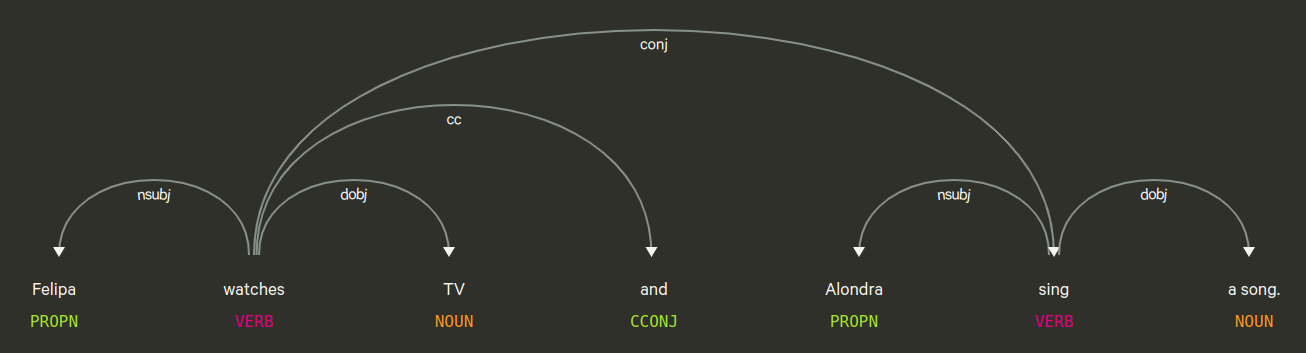

## Connect Google Drive

*   Run the cell "Connect Google Drive" and on the popup window click  "Connect to Google Drive".

*   In the new page opened, choose an account (your account) and click Allow.

## Configuration parameters

* **Data source directory**: The data source directory that will be used for loading the data source file for splitting.

* **Data source file**: The data source file that will be loaded for splitting.

# Installations

In [ ]:
!pip install spacy==3.4.1

# Imports

In [ ]:
import os, datetime, spacy, json, string

import pandas as pd

import numpy as np

from pathlib import Path

from typing import List, Union

from spacy.tokens import Doc

from google.colab import drive

import ipywidgets as widgets

# Functions / Classes


In [ ]:
class RuleBasedSentenceSplitting:
  def __init__(self):
    self._model = spacy.load('en_core_web_sm', exclude=["lemmatizer", "ner"])

  def split_sentences_using_conjunctions(self, sentences: Union[List[str], np.ndarray, pd.Series]) -> List[str]:
    return list(map(self._split_sentence_using_conjunctions, self._model.pipe(sentences, batch_size=50)))
  
  def _fix_sentences_punctation(self, sentences: List[str]) -> List[str]:
    if not sentences: return sentences

    last_sentence = sentences.pop(-1)

    final_sentences = []
    
    for sentence in sentences:
      final_sentences.append(sentence.strip(' ,'))
    
    final_sentences.append(last_sentence.lstrip(' ,'))
    
    return final_sentences

  def _split_sentence_using_conjunctions(self, sentence: Doc) -> str:
    punctuation_symbols = set(string.punctuation)

    splitted_sentences = []
    
    last_idx = None

    for token in sentence:
      if token.pos_ == 'CCONJ': 
        if token.head.conjuncts:
          closest_token_right = None

          for conjunct_token in token.head.conjuncts:
            if conjunct_token.i > token.i:
              closest_token_right = conjunct_token
              break

          if closest_token_right:      
            if token.head.pos_ == closest_token_right.pos_ == 'VERB':
              new_sentence = sentence[:token.i].text if last_idx is None else sentence[last_idx:token.i].text

              if set(new_sentence).difference(punctuation_symbols):
                splitted_sentences.append(new_sentence[0].upper() + new_sentence[1:])

              last_idx = token.i + 1

    if last_idx is None:
      return sentence.text

    if len(sentence[last_idx:]) > 0:
      splitted_sentences.append(sentence[last_idx:].text[0].upper() + sentence[last_idx:].text[1:])

    return '. '.join(self._fix_sentences_punctation(splitted_sentences))

def get_csv_file_names_from_directory_path (directory_path: Union[Path, str]) -> List[str]:
  return [ f for f in os.listdir(directory_path) if f.endswith('.csv') ]

# Connect Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

# Create paths

In [ ]:
MODELING_DATA_DIRECTORY_PATH = Path('/content/drive/My Drive/Pfizer - Long Sentence Resolution/Datasets/modeling')

MODELS_DIRECTORY_PATH = Path('/content/drive/My Drive/Pfizer - Long Sentence Resolution/Models')

MODELS_DIRECTORY_PATH.mkdir(parents=True, exist_ok=True)

# Configuration parameters

In [ ]:
def on_data_source_directory_dropdown_change(change):
  file_names = get_csv_file_names_from_directory_path(MODELING_DATA_DIRECTORY_PATH / change.new)

  if not file_names: raise ValueError('The selected data source contains no CSV files.')

  data_source_file_dropdown.options = file_names

  data_source_file_dropdown.value = data_source_file_dropdown.options[0]

data_source_directory_dropdown = widgets.Dropdown(options=list(filter(lambda o: o.startswith('splitting_dataset'), os.listdir(MODELING_DATA_DIRECTORY_PATH))))
data_source_file_dropdown = widgets.Dropdown(options=get_csv_file_names_from_directory_path(MODELING_DATA_DIRECTORY_PATH / data_source_directory_dropdown.value))

data_source_directory_dropdown.observe(on_data_source_directory_dropdown_change, names='value')

display(widgets.HBox([widgets.Label(value="Data source directory:"), data_source_directory_dropdown]))
display(widgets.HBox([widgets.Label(value="Data source file:"), data_source_file_dropdown]))

# Create model

In [ ]:
rule_based_sentence_splitting = RuleBasedSentenceSplitting()

# Run model on test examples

In [ ]:
%%time

rule_based_sentence_splitting.split_sentences_using_conjunctions([
    "They entered the house and she glanced at the dark fireplace.",
    "Meyers helps her with the money but warns her not to tell anybody, and fires her from the campaign to make the problem go away.",
    "Felipa and Alondra sing a song.",
    "Douglas was born in 1969 in Kent, Washington and graduated from Kentridge High School and later attended Washington State University.",
    "Jessica watches TV and eats dinner.",
    "Ram eats a banana and an apple but sings a song.",
    "But true strained yogurt is made by draining the yogurt in a (preferably muslin) cloth and is called 'chakka' in some parts of India.",
    "He washed cars over the weekend and now has 86 dollars.",
    "He refuses to agree with her and burns her to ashes trying to prove her wrong and performs his 'Tandava', which is noticed by the Devas, who pacify him."
])

# Load data file

In [ ]:
data_file_df = pd.read_csv(MODELING_DATA_DIRECTORY_PATH / data_source_directory_dropdown.value / data_source_file_dropdown.value, usecols=['source'])

data_file_df

# Run model on loaded data file

In [ ]:
%%time

data_file_df['prediction'] = rule_based_sentence_splitting.split_sentences_using_conjunctions(data_file_df['source'])

data_file_df

# Save generated predictions

In [ ]:
output_directory_path = MODELS_DIRECTORY_PATH / f'splitting_model_{datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

os.makedirs(output_directory_path)

with open(output_directory_path / 'generated_predictions.txt', 'w') as f: f.write('\n'.join(data_file_df['prediction']))

# Save configuration

In [ ]:
with open(output_directory_path / 'config.json', 'w') as f: json.dump({
  'model_name' : 'rule-based-sentence-splitting',
  'data_source_directory' : data_source_directory_dropdown.value,
  'data_source_file' : data_source_file_dropdown.value,
}, f, sort_keys=True, indent=4)